### Import Libraries

In [4]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [5]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

### Dataset

In [7]:
if UNZIP_DATASET:
    !unzip 'training_dataset.zip'

In [8]:
train_data_new = pd.DataFrame(np.load("train2.npy")) # dataset built as shown in the report
categories_new = pd.DataFrame(np.load("cat2.npy", allow_pickle=True), columns=['Category']) #contains category of the series: {'A', 'B', 'C', 'D', 'E', 'F'}.

### Preparing the model

In [9]:
X_train = train_data_new.iloc[:,:-18] # First 191 values of each time sequence of train2 as input.
Y_train = train_data_new.iloc[:,-18:] # Last 18 values of each time sequence of train2 as target output.
X_train.shape, Y_train.shape

((267676, 191), (267676, 18))

In [10]:
input_shape = X_train.shape[1]
output_shape = Y_train.shape[1]
input_shape, output_shape

(191, 18)

### Bahdanau Attention Layer


In [11]:
# implementing attention by subclassing the Layer class
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):  # writing __init__ method to override the following methods: build() and call()
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape): # This method “lazily” creates weights. The built-in function add_weight() can be used to add the weights and biases of the attention layer.
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x): # The call() method implements the mapping of inputs to outputs. It should implement the forward pass during training.
        # Alignment scores. Pass them through tanh function
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = tf.keras.backend.squeeze(e, axis=-1)
        # Compute the weights
        alpha = tf.keras.backend.softmax(e)
        # Reshape to tensorFlow format
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)
        return context

### Conv1Ds ResNet

In [16]:
def build_model( input_shape, output_shape):
        n_feature_maps = 64

        input_layer = tf.keras.layers.Input(shape=(input_shape,1))

        # BLOCK 1

        conv_x = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer) # Beginning with n_feature maps filters.
        conv_x = tf.keras.layers.BatchNormalization()(conv_x)
        conv_x = tf.keras.layers.Activation('relu')(conv_x)

        conv_y = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = tf.keras.layers.BatchNormalization()(conv_y)
        conv_y = tf.keras.layers.Activation('relu')(conv_y)

        conv_z = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = tf.keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

        output_block_1 = tf.keras.layers.add([shortcut_y, conv_z])
        output_block_1 = tf.keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1) # Increasing the number of filters to n_feature_maps * 2
        conv_x = tf.keras.layers.BatchNormalization()(conv_x)
        conv_x = tf.keras.layers.Activation('relu')(conv_x)

        conv_y = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = tf.keras.layers.BatchNormalization()(conv_y)
        conv_y = tf.keras.layers.Activation('relu')(conv_y)

        conv_z = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = tf.keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

        output_block_2 = tf.keras.layers.add([shortcut_y, conv_z])
        output_block_2 = tf.keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3
        # We freezed this block because it yielded a too complex model.

        #conv_x = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        #conv_x = tf.keras.layers.BatchNormalization()(conv_x)
        #conv_x = tf.keras.layers.Activation('relu')(conv_x)

        #conv_y = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        #conv_y = tf.keras.layers.BatchNormalization()(conv_y)
        #conv_y = tf.keras.layers.Activation('relu')(conv_y)

        #conv_z = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        #conv_z = tf.keras.layers.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        #shortcut_y = tf.keras.layers.BatchNormalization()(output_block_2)

        #output_block_3 = tf.keras.layers.add([shortcut_y, conv_z])
        #output_block_3 = tf.keras.layers.Activation('relu')(output_block_3)

        # FINAL

        att_layer = attention()(output_block_2) # substituting the previously shown attention layer to the Global Average Pooling Layer

        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(att_layer)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

        return model


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 191, 1)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 191, 64)              576       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 191, 64)              256       ['conv1d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_3 (Activation)   (None, 191, 64)              0         ['batch_normalization_4[

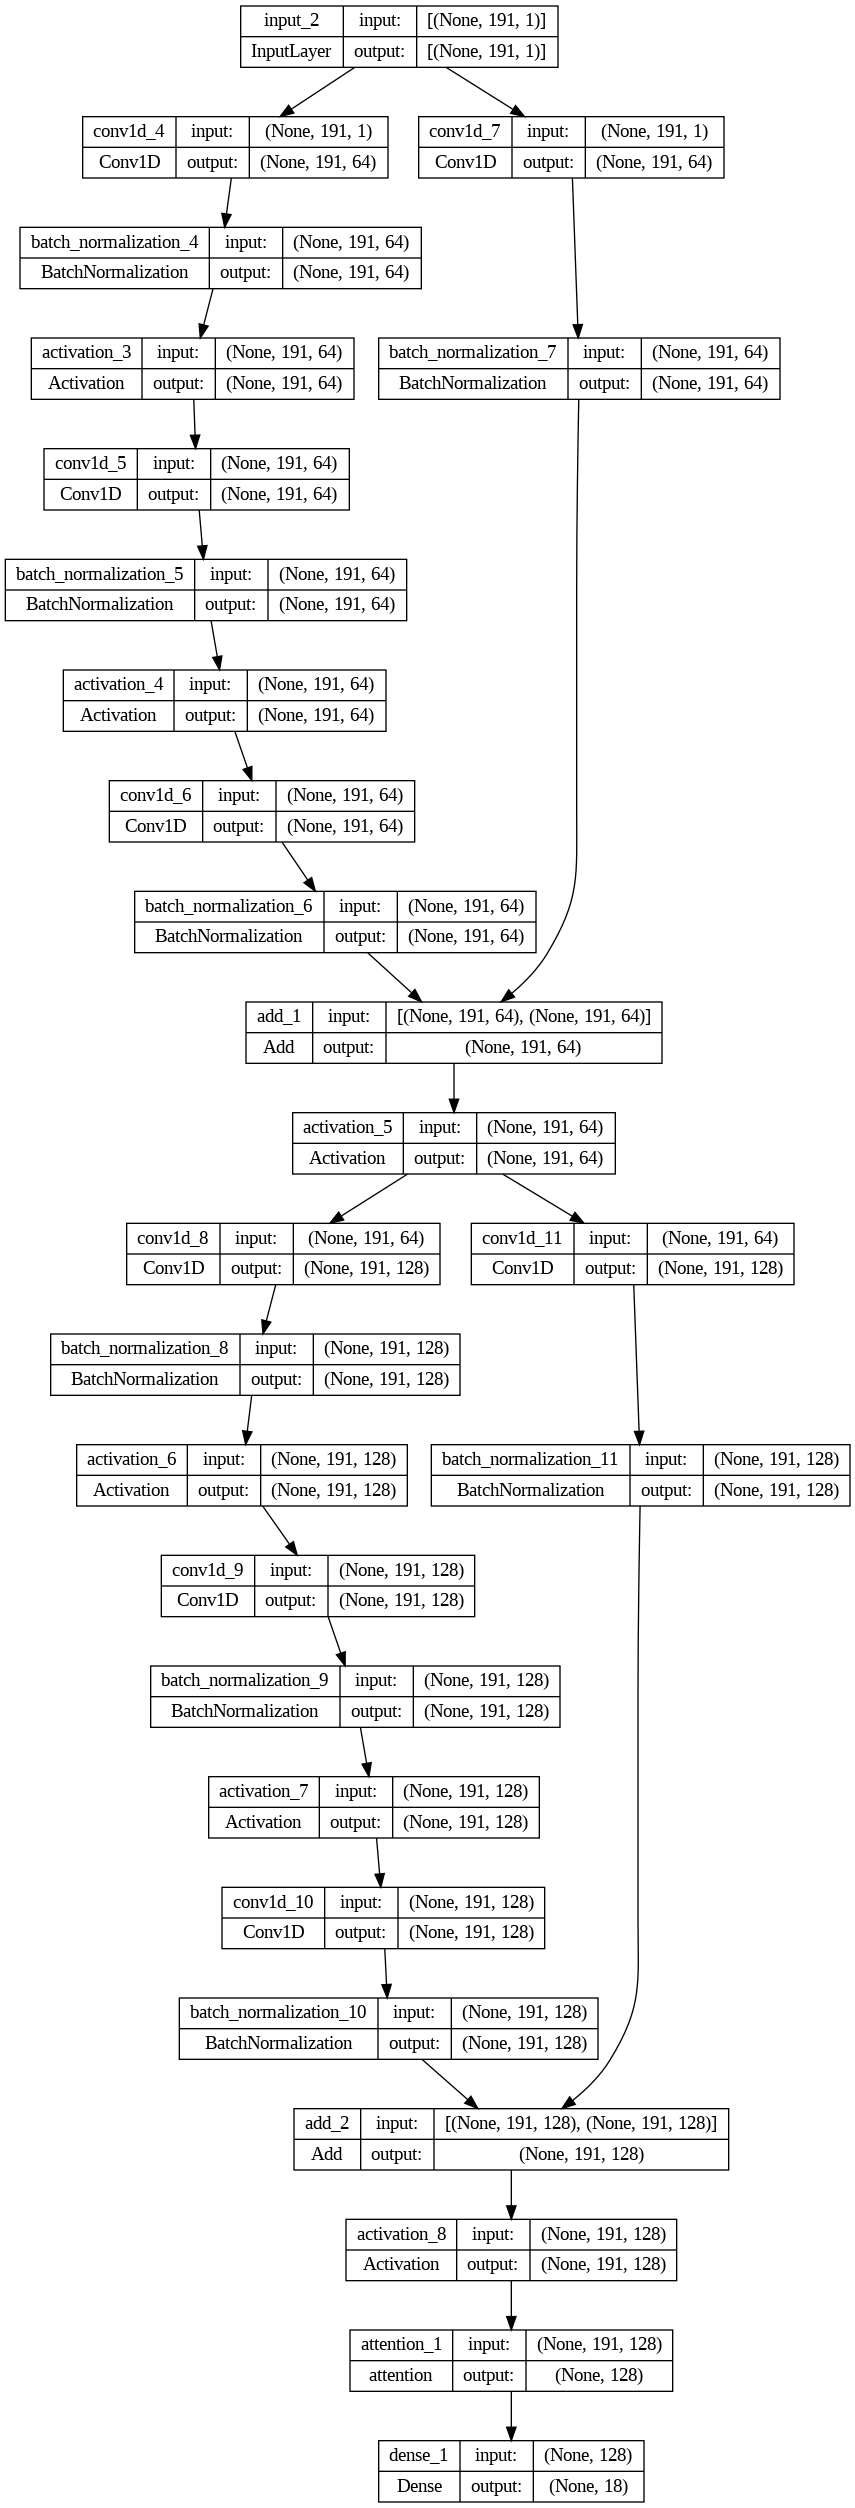

In [17]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [18]:
batch_size = 60
epochs = 200
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
4016/4016 [==============================] - 86s 19ms/step - loss: 0.0128 - val_loss: 0.0126 - lr: 0.0010
Epoch 2/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0100 - val_loss: 0.0126 - lr: 0.0010
Epoch 3/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0093 - val_loss: 0.0141 - lr: 0.0010
Epoch 4/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0089 - val_loss: 0.0112 - lr: 0.0010
Epoch 5/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0086 - val_loss: 0.0111 - lr: 0.0010
Epoch 6/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0083 - val_loss: 0.0124 - lr: 0.0010
Epoch 7/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0081 - val_loss: 0.0146 - lr: 0.0010
Epoch 8/200
4016/4016 [==============================] - 73s 18ms/step - loss: 0.0079 - val_loss: 0.0114 - lr: 0.0010
Epoch 9/200
4016/4016 [==============================] -

### Plotting results

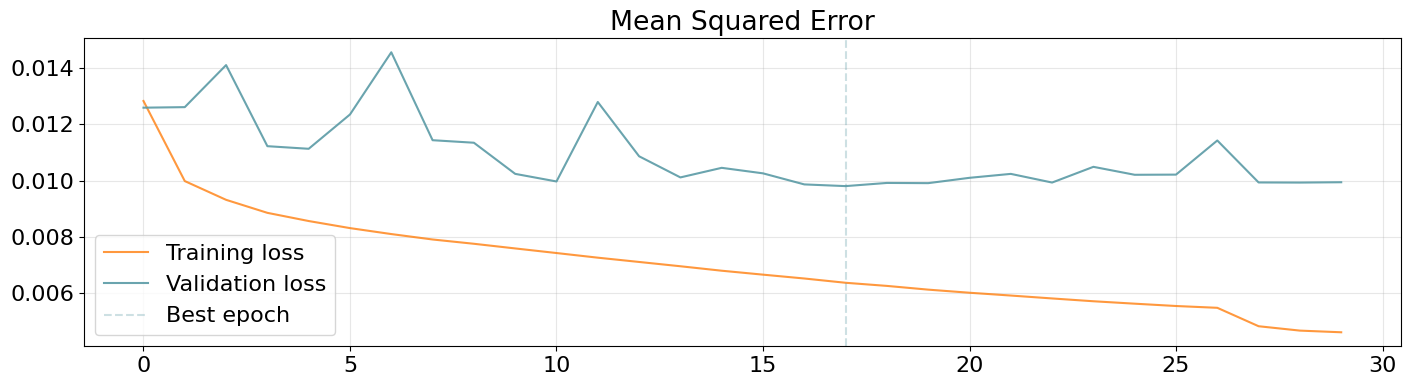

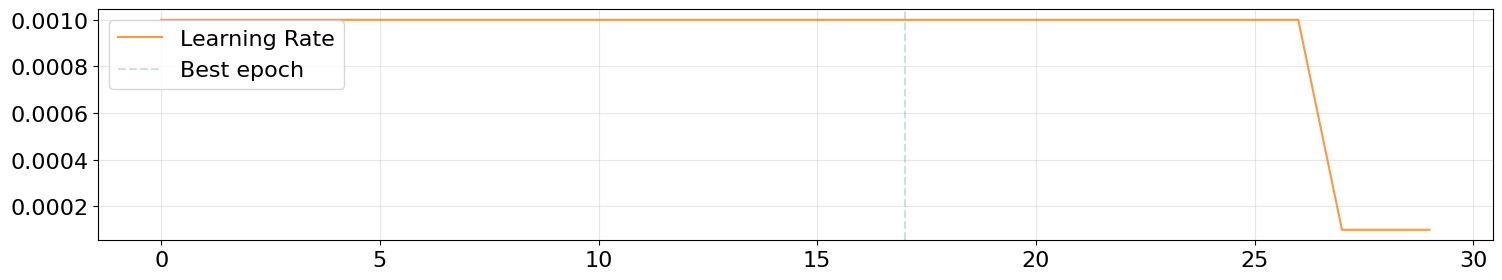

In [19]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [20]:
model.save('Conv1ds_attention')
